# Objective

The goal of this project is to generate a segmentation mask for neurons that differentiates the soma and neurites from the background.
We'll be doing this using a variant of U-net, which is a common choice for segmentation tasks in cellular biology. With the model defined,
we then train it on the synthetically generated data.

## Notebook Overview

- Import Dependencies
- Configure Logging and Define Constants and Paths
- Model architecture and implementation
- Dataloader / preprocessing
- Training and Validation
- Inference
- HR and LR image comparasion

## Import Dependencies

In [1]:
# Standard Library Imports
import logging
import time
import os
from pathlib import Path
from dataclasses import dataclass

# Third-Party Libraries
import numpy as np
import matplotlib. pyplot as plt 
import torch
from torch import nn, Tensor
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2.functional as FT
from torchvision.utils import make_grid
from torchvision.io import read_image
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

# MLflow for Experiment Tracking and Model Management
import mlflow

# Configure Logging and Define Constants and Paths

In [2]:
# Configure the logging module with desired format and level
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create a logger for this notebook
logger = logging.getLogger('segmentation-notebook')
logger.info("Logging configured successfully")

2025-06-07 21:53:07 - segmentation-notebook - INFO - Logging configured successfully


In [3]:
# Define global experiment and run names to be used throughout the notebook
PROJECT_NAME = 'neuron_segmentation'
RUN_NAME = "neuron_segmentation_main"
MODEL_NAME = "neuron_segmentation"
MLFLOW_EXPERIMENT = "Neuron Segmentation"
# Set up the paths
TENSORLOGS_PATH =  '../data/tensorboard'
TRAIN_PATH = '../data/imagery/train'
VALIDATION_PATH = '../data/imagery/val'
BEST_MODEL_PATH = 'best_model.pth'
MODEL_PATH = 'neuron_segmentation.pt'

# Set up the chunk separator for text processing
CHUNK_SEPARATOR = "\n\n"

os.environ['TENSORBOARD_LOGDIR'] = '../data/tensorboard'

# Model Architecture and Implementation

The U-net model, in general, works by successively encoding features until the spatial resolution has been downsized by factor of 4 or 8.
After that, the model progressively up samples and concatenates features from prior encoding states. It can be thought of as an auto encoder
with skip connections. There are several variations, such as the addition of residual blocks or residual connections, but we will be using
the foundational version. The nice thing about U-net is that it is fully convolutional, so even if we train with a small spatial resolution,
we can use larger spatial resolutions during deployment.

Here is a diagram that illustrates what is happening visually.

<p align="center">
    <img src="../docs/unet.png" />
</p>

Many variants of U-net will go deeper, and many will also have batch normalization and activation functions.

In [4]:
class _Encoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        skip = x
        x = self.conv(x)
        x = self.norm(x)
        x = F.leaky_relu(x)
        return x, skip

class _Decoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor, skip: Tensor) -> Tensor:
        shape = (skip.shape[2], skip.shape[3])
        x = F.interpolate(x, size=shape, mode='bilinear')
        x = torch.concat((x, skip), dim=1)
        x = self.conv(x)
        x = self.norm(x)
        x = F.leaky_relu(x)
        return x

class UNet(nn.Module):
    """
    A class for building the architecture of the U-net model.
    """
    def __init__(self, input_features: int = 1):
        """
        Initializes the network.
        Args:
            input_features: The number of channels used by the input image. For microscopy, this is generally single
                            channel, but it is sometimes 3 channels for widefield microscopy. For confocal microscopy,
                            this may be many channels, where each represents a thin slice of the specimen along the Z axis.
        """
        try:
            super().__init__()
            self.input_features = input_features
            self.enc1 = _Encoder(input_features, 16)
            self.enc2 = _Encoder(16, 128)
            self.enc3 = _Encoder(128, 256)
            self.dec3 = _Decoder(256 + 128, 128)
            self.dec2 = _Decoder(128 + 16, 16)
            self.dec1 = _Decoder(16 + 1, 3)
            logger.info("U-net initialization done successfully")
        except Exception as e:
            logger.error(f"Error initializing U-net: {e}")
            raise    

    def forward(self, x: Tensor) -> Tensor:
        """ 
        Implementation of the U-net logic, in which, the input passes through every step of the architecture.
        Args:
            x: Input image from microscope.

        Returns:
            x: The segmentation mask.
        """
        try:
            x, skip0 = self.enc1(x)
            x, skip1 = self.enc2(x)
            x, skip2 = self.enc3(x)
            x = self.dec3(x, skip2)
            x = self.dec2(x, skip1)
            x = self.dec1(x, skip0)
            return x
        except Exception as e:
            logger.error(f"Error implementing U-net logic: {e}")
            raise 

    def smoke_test(self, res: tuple[int, int] = (512, 512)):
        batch_size = 4
        x = torch.randn((batch_size, self.input_features, res[0], res[1]))
        self.eval()
        try:
            self.forward(x)
        except Exception as e:
            logger.error(f'Failed to run basic network test: {e}')
            raise

net = UNet()
net.smoke_test()

2025-06-07 21:53:07 - segmentation-notebook - INFO - U-net initialization done successfully


# Dataloader / preprocessing

In [5]:
@dataclass
class _Sample:
    image: Path | Tensor
    target: Path | Tensor

class SegmentationDataset(Dataset):
    def __init__(self, img_dir: Path):
        """
        Initialize the segmentation dataset.

        Args:
            img_dir: Image directory.
        """
        try:
            super().__init__()
            self.samples: list[_Sample] = []
            for entry in img_dir.glob('*'):
                if 'mask' in entry.stem:
                    continue
                index = int(str(entry.stem))
                mask_entry = img_dir / f'{index:05}_mask.png'
                self.samples.append(_Sample(image=entry, target=mask_entry))

            logger.info(f"Segmentation dataset initialization done successfully (num_samples={len(self.samples)})")

        except Exception as e:
            logger.error(f"Error initializing segmentation dataset: {e}")
            raise

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        """
        Gets an input image and the target segmentation mask.

        Args:
            index: The index of the sample in the dataset.

        Returns:
            An input image and a target segmentation mask.
        """
        try:
            sample = self.samples[index]
            if isinstance(sample.image, Path):
                sample.image = read_image(str(sample.image)).float() * (1.0 / 255.0)
            if isinstance(sample.target, Path):
                sample.target = read_image(str(sample.target)).float() * (1.0 / 255.0)
            image = sample.image
            target = sample.target
            return image, target
        
        except Exception as e:
            logger.error(f"Error getting sample: {e}")
            raise

    def __len__(self):
        """
        Get the number of input and output pairs.

        Returns:
            The number of input and output pairs.
        """
        return len(self.samples)


# Training and Validation

In [6]:
class TrainUNet(object):
    def __init__(self, model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, train_loader: DataLoader, val_loader: DataLoader, n_epochs: int, device):
        """
        Initialize the model training object.

        Args:
            model: U-net model.
            criterion: Measures the error between the output and the real value.
            optimizer : Adjusts model weights for loss minimization.
            train_loader: Training batches.
            val_loader: Validation batches.
            n_epochs: Number of epochs for the training.
            device: Where the model and data will be processed.
        """
        try:
            self.model = model
            self.criterion = criterion
            self.optimizer = optimizer
            self.train_loader = train_loader
            self.val_loader = val_loader
            self.n_epochs = n_epochs
            self.device = device
            self.log_dir = TENSORLOGS_PATH
            self.mlflow_exp_name = PROJECT_NAME
            self.tb_writer = torch.utils.tensorboard.SummaryWriter()
            self.best_metric = float('inf')
            self.best_epoch = -1

            logger.info("Training object initialization done successfully")
            
        except Exception as e:
            logger.error(f"Error initializing training object: {e}")

    def train(self):
        """
        Train the U-net model
        """
        try:
            start_time = time.time()

            writer = SummaryWriter(self.log_dir)
            mlflow.set_tracking_uri('../data/mlflow')
            mlflow.set_experiment(self.mlflow_exp_name)

            self.model = self.model.to(self.device)
            self.model.train()

            outer_loop = tqdm(range(self.n_epochs))

            for epoch in outer_loop:
                running_loss = 0.0
                outer_loop.set_description(f"Epoch [{epoch}/{self.n_epochs}]")
                for i, (image, target) in tqdm(enumerate(self.train_loader)):
                    image: Tensor = image.to(self.device)
                    target: Tensor = target.to(self.device)

                    predicted = self.model(image)
                    loss: Tensor = self.criterion(predicted, target)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()

                self.log_images_to_tensorboard(writer, epoch)

                # Validate on the validation set
                val_loss, val_psnr = self.validate()

                logger.info("Epoch: %d, Loss: %.3f, Validation Loss: %.3f" %
                    (epoch + 1, running_loss / len(self.train_loader), val_loss, val_psnr))
                
                if running_loss < self.best_metric:
                    torch.save(self.model.state_dict(), BEST_MODEL_PATH)
                    best_metric = running_loss

            writer.close()

            with mlflow.start_run(run_name = RUN_NAME) as run:
                logger.info(run.info.run_id)
                #mlflow.log_metric("Training RMSE", running_loss)
                #mlflow.log_metric("Validation RMSE", val_loss)
                #mlflow.log_metric("Validation PSNR", val_psnr)
                mlflow.register_model(model_uri = f"runs:/{run.info.run_id}/fscnn", name = MODEL_NAME)

            # Add a timer to calculate the training time
            end_time = time.time()
            total_time = end_time - start_time

            logger.info('Total time of training: {:.2f} seconds'.format(total_time))

        except Exception as e:
            logger.error(f"Error training model: {str(e)}")

    def log_images_to_tensorboard(self, writer, epoch):
        """
        Log images on the tensorboard to monitor model training.

        Args:
            writer: Instance of the tensorboard SummaryWriter class, used to "write" in a format that the tensorboard can "read"
            epoch: Epoch of each image
        """
        self.model.eval()
        try:
            with torch.no_grad():
                # Get a batch from the validation set
                hr, lr = next(iter(self.val_loader))
                hr = hr.to(self.device)
                lr = lr.to(self.device)

                # Forward pass
                outputs = self.model(lr)

                # Convert images to a grid for visualization
                grid_hr = make_grid(hr, nrow=1, normalize=True)
                grid_lr = make_grid(lr, nrow=1, normalize=True)
                grid_sr = make_grid(outputs, nrow=1, normalize=True)

                # Log images to TensorBoard
                writer.add_image(f'Original/Epoch_{epoch + 1}', grid_hr, epoch)
                writer.add_image(f'Low Resolution/Epoch_{epoch + 1}', grid_lr, epoch)
                writer.add_image(f'Super-Resolved/Epoch_{epoch + 1}', grid_sr, epoch) 

        except Exception as e:
            logger.error(f"Error logging on tensorboard: {str(e)}")      

    def validate(self):
        """
        Validates training by calculating some metrics that were defined.

        Returns:
            Metrics used to evaluate training.
        """
        try:
            self.model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_psnr = 0.0
                val_loop = tqdm(self.val_loader)
                count = 0
                for image, target in self.val_loader:
                    image: Tensor = image.to(self.device)
                    target: Tensor = target.to(self.device)
                    predicted = self.model(image)
                    loss: Tensor = self.criterion(predicted, target)
                    val_loss += loss.item()
                    count += 1
                    val_loop.set_description(f"Validation: Loss = {val_loss / count}")
                val_loop.close()
                return val_loss / len(self.val_loader), val_psnr / len(self.val_loader)
            
        except Exception as e:
            logger.error(f"Error validating training: {str(e)}")
            raise

    def device_validate(self):
        """
        Validation of the used device.

        Returns:
            The device validation
        """
        self.model = self.model.to(self.device)
        return self.validate()


The evaluation parameters used are:
- Loss: Evaluates the error in the data on which the model is learning. A decreasing loss means that the model is learning and improving
- Validation Loss: Evaluates the performance of the model on the validation set. It indicates how well the model can generalize to new data. In this case, it measures the error on the validation data. The lower the validation loss value, the better, meaning that the model is generalizing well.
- Validation PSNR: This is a metric used to evaluate the quality of an image reconstruction compared to the original image in the case of a high-resolution image.

In [7]:
class Args:
    train_dir = TRAIN_PATH
    val_dir = VALIDATION_PATH
    scale = 4
    batch_size = 4
    epochs = 300

args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(device)

mlflow.set_experiment(MLFLOW_EXPERIMENT)

# Load training dataset
train_dataset = SegmentationDataset(Path(args.train_dir))

# Load validation dataset
val_dataset = SegmentationDataset(Path(args.val_dir))

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

model = UNet(input_features=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_fsrcnn = TrainUNet(model, criterion, optimizer, train_loader, val_loader, args.epochs, device)

train_fsrcnn.train()


2025-06-07 21:53:07 - segmentation-notebook - INFO - cuda
2025-06-07 21:53:07 - segmentation-notebook - INFO - Segmentation dataset initialization done successfully (num_samples=2240)
2025-06-07 21:53:07 - segmentation-notebook - INFO - Segmentation dataset initialization done successfully (num_samples=600)
2025-06-07 21:53:07 - segmentation-notebook - INFO - U-net initialization done successfully
2025-06-07 21:53:07 - segmentation-notebook - INFO - Training object initialization done successfully


  0%|          | 0/300 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2025-06-07 21:53:53 - segmentation-notebook - ERROR - Error implementing U-net logic: Given groups=1, weight of size [16, 1, 3, 3], expected input[4, 3, 512, 512] to have 1 channels, but got 3 channels instead
2025-06-07 21:53:53 - segmentation-notebook - ERROR - Error logging on tensorboard: Given groups=1, weight of size [16, 1, 3, 3], expected input[4, 3, 512, 512] to have 1 channels, but got 3 channels instead


  0%|          | 0/150 [00:00<?, ?it/s]

2025-06-07 21:53:58 - segmentation-notebook - ERROR - Error training model: not all arguments converted during string formatting


# Inference

In [8]:
torch.save(model.state_dict(), MODEL_PATH)

2025-06-07 22:04:22 - segmentation-notebook - INFO - U-net initialization done successfully
2025-06-07 22:04:22 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025462879..15.225865].


Predicted image torch.Size([1, 3, 512, 512])
High Resolution Image torch.Size([1, 3, 512, 512])


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

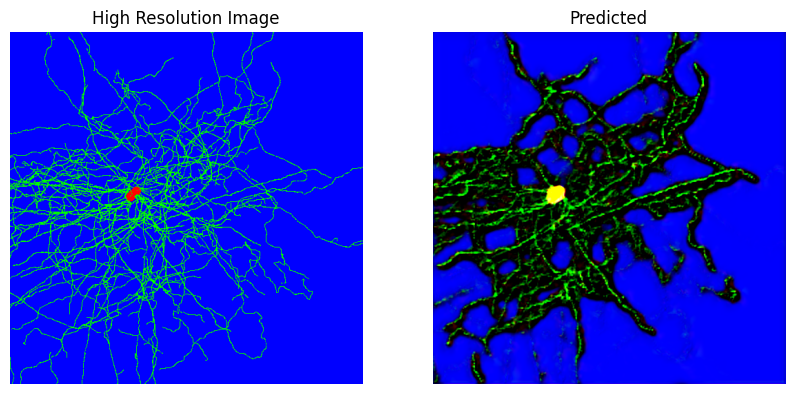

In [17]:
model = UNet(input_features=1)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

x_batch, y_batch = next(iter(val_loader))
x, y = x_batch[0], y_batch[0]
x = x.to(device).unsqueeze(dim=0)
y = y.unsqueeze(dim=0)
pred = model(x)
pred = pred.cpu()
print('Predicted image', pred.shape)
print('High Resolution Image', y.shape)

# Convert tensors to numpy arrays 
y = y[0].numpy().transpose(1, 2, 0)
pred = pred[0].detach().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title('High Resolution Image')
axes[0].axis('off')

axes[1].imshow(pred)
axes[1].set_title('Predicted')
axes[1].axis('off')


# HR and LR image comparasion

High Resolution image torch.Size([1020, 2040, 3])
Low Resolution image torch.Size([255, 510, 3])


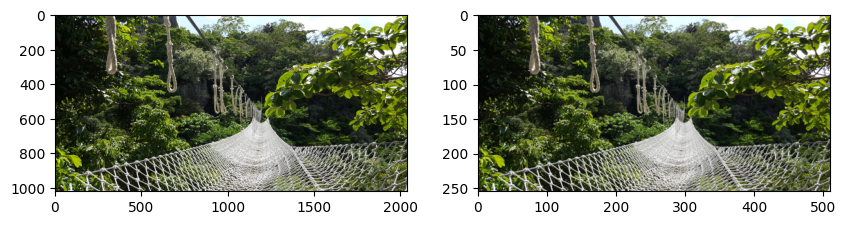

In [ ]:
def train_imgs_visualization():
    """ 
    Does the plot for the training image
    """
    for imgs in train_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        print('High Resolution image', img1.shape)
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        print('Low Resolution image', img2.shape)
        break

def val_imgs_visualization():
    """ 
    Does the plot for the validation image
    """
    for imgs in val_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        break

train_imgs_visualization()

Built with ❤️ using Z by HP AI Studio.